# Random Forest만으로 경진대회 참여

## Load Dataset

In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 적용
plt.style.use('ggplot')

# 한글 폰트 깨지는 문제 해결
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False 

### train data

In [30]:
train = pd.read_csv('02_bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

### test data

In [31]:
test = pd.read_csv('02_bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

## Feature Engineering

In [32]:
train = pd.read_csv('02_bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [33]:
# 시각화하기 편하게 하기 위해 ["year", "month", "day", "hour", "minute", "second"] Column 추가
train["year"] = train["datetime"].dt.year 
train["month"] = train["datetime"].dt.month 
train["day"] = train["datetime"].dt.day 
train["hour"] = train["datetime"].dt.hour 
train["minute"] = train["datetime"].dt.minute 
train["second"] = train["datetime"].dt.second 
train["dayofweek"] = train["datetime"].dt.dayofweek 
train.shape

(10886, 19)

In [34]:
test = pd.read_csv('02_bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [35]:
# 시각화하기 편하게 하기 위해 ["year", "month", "day", "hour", "minute", "second"] Column 추가
test["year"] = test["datetime"].dt.year 
test["month"] = test["datetime"].dt.month 
test["day"] = test["datetime"].dt.day 
test["hour"] = test["datetime"].dt.hour 
test["minute"] = test["datetime"].dt.minute 
test["second"] = test["datetime"].dt.second 
test["dayofweek"] = test["datetime"].dt.dayofweek 
test.shape

(6493, 16)

<AxesSubplot: title={'center': 'test windspeed'}, xlabel='windspeed', ylabel='count'>

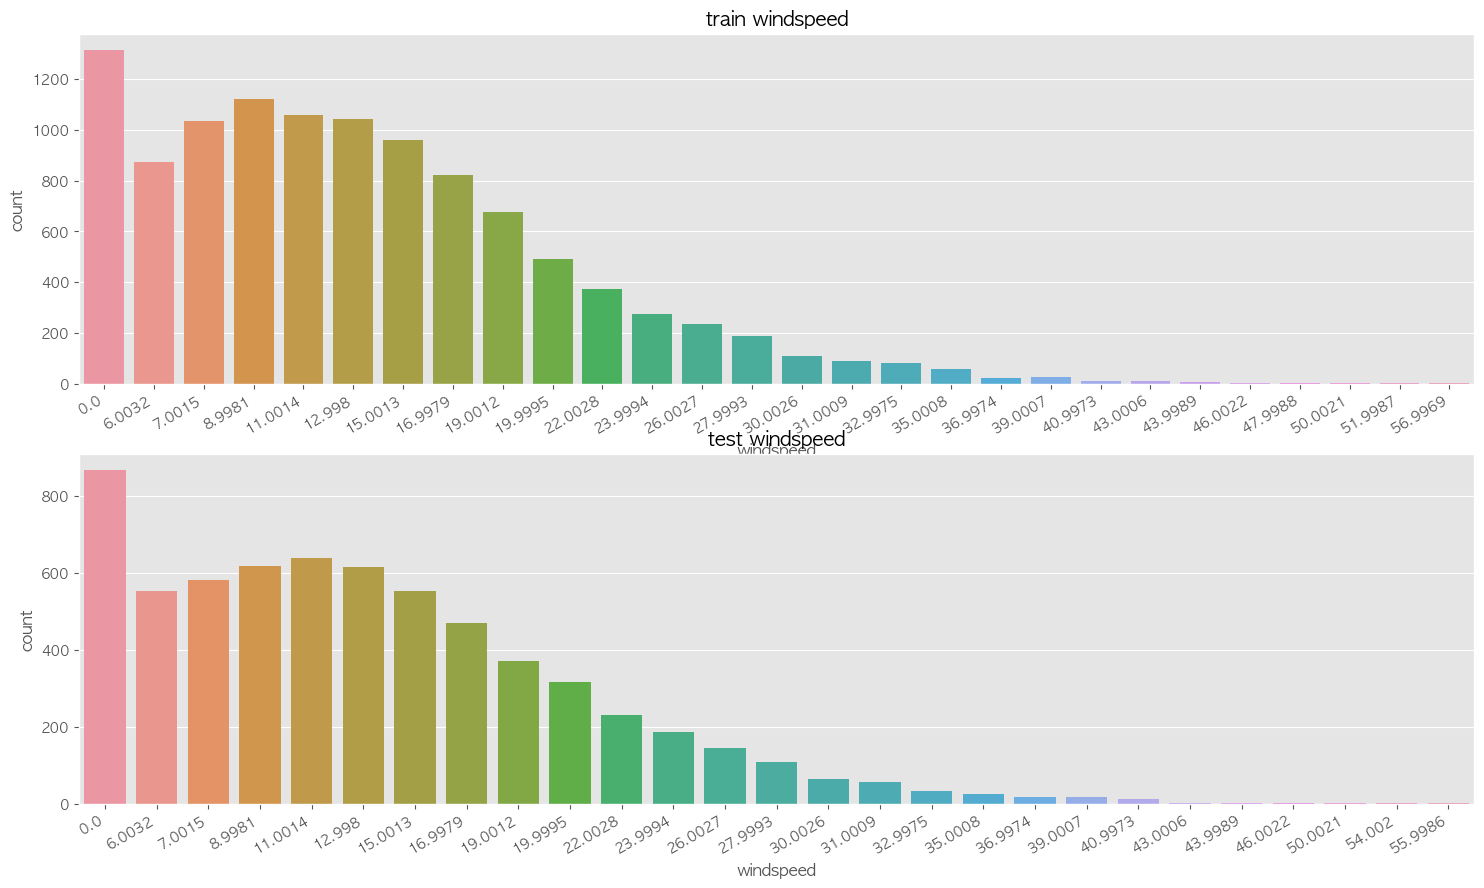

In [36]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [37]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [38]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [39]:
# 그래서 머신러닝으로 풍속을(0인 풍속에 대해서) 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/4272548903.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/4272548903.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictWind0["windspeed"] = wind0Values
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/4272548903.py:34: FutureWarning: The frame.append method is deprecated and will b

<AxesSubplot: title={'center': 'train windspeed'}, xlabel='windspeed', ylabel='count'>

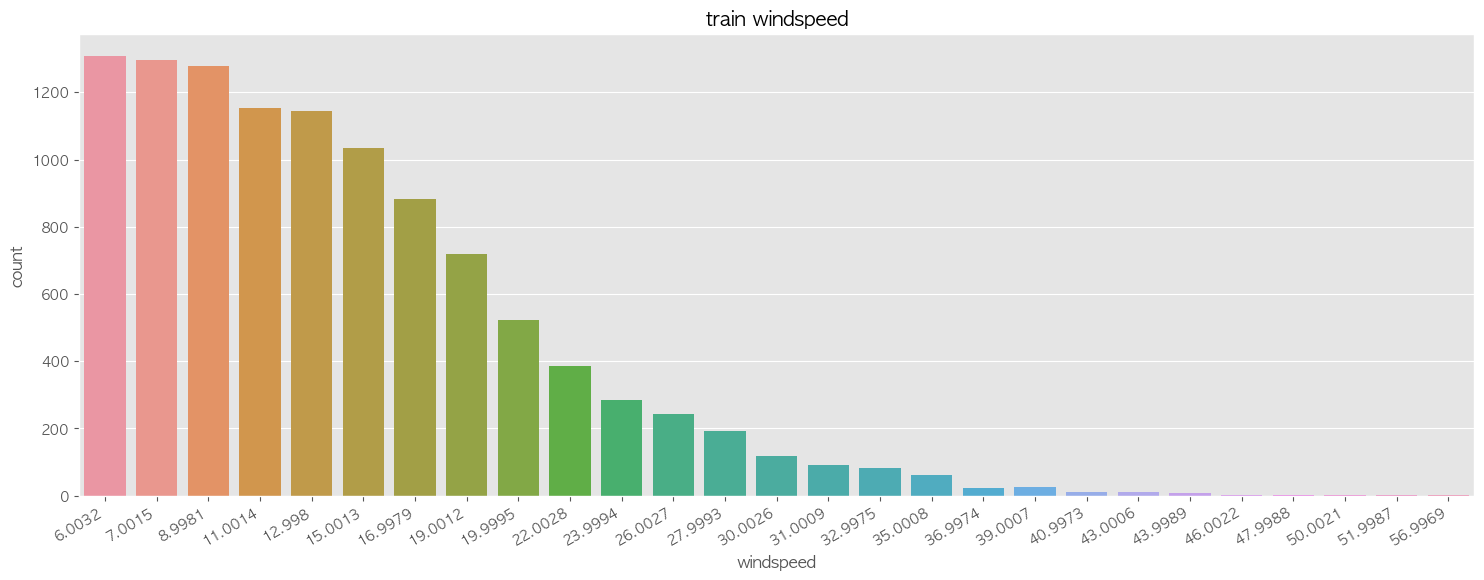

In [40]:
# 0값을 조정한다.
train = predict_windspeed(train)
test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

## Feature Selection
* 신호와 잡음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [41]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [42]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

In [43]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()


(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [44]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
2,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1
3,1,1,9.84,11.365,60,15.0013,2011,5,3,0,1
4,1,1,9.02,10.605,60,15.0013,2011,6,3,0,1


In [45]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## RMSE 

과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$
 
 $n$ is the number of hours in the test set

 $p_i$ is your predicted count

 $a_i$ is the actual count

 $log(x)$ is the natural logarithm

좀 더 자세한 설명은 : RMSLE cost function

잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해

정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.

값이 작을 수록 오류가 적다는 의미를 나타낸다.



In [46]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation 교차 검증

일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.

`KFold 교차검증`
* 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
* 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
* 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
* 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
* 이 과정을 마지막 폴드까지 반복한다.
* 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.

In [47]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest

In [48]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [49]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 1.18 s, sys: 734 ms, total: 1.91 s
Wall time: 4.92 s
Score= 0.33060


## Train

In [50]:
# 학습
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [51]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.69,   3.47,   3.13,   6.18,  38.32, 104.98, 235.83, 136.13,
        63.08,  64.11])

/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/1535772313.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,ax=ax1,bins=50)
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/1535772313.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions,ax=a

[Text(0.5, 1.0, 'test')]

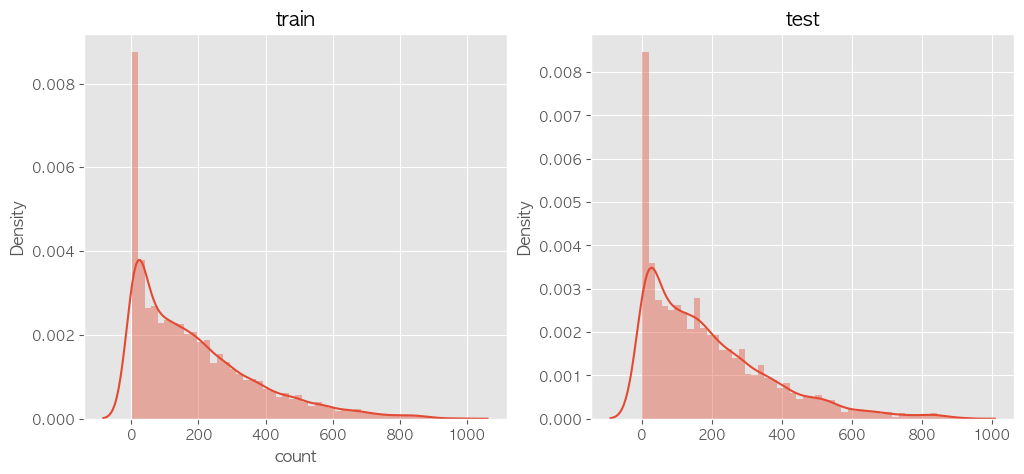

In [52]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)

fig.set_size_inches(12,5)

sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

## Submit

In [53]:
submission = pd.read_csv("02_bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.69
1,2011-01-20 01:00:00,3.47
2,2011-01-20 02:00:00,3.13
3,2011-01-20 03:00:00,6.18
4,2011-01-20 04:00:00,38.32


In [54]:
submission.to_csv("02_bike-sharing-demand/Score_{0:.5f}_submission.csv".format(score), index=False)

# 다양한 기법으로 경진대회 참여

## Load Dataset

In [55]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 적용
plt.style.use('ggplot')

# 한글 폰트 깨지는 문제 해결
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False 

### train data

In [56]:
train = pd.read_csv('02_bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

### test data

In [57]:
test = pd.read_csv('02_bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

## Feature Engineering

In [58]:
train = pd.read_csv('02_bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [59]:
# 시각화하기 편하게 하기 위해 ["year", "month", "day", "hour", "minute", "second"] Column 추가
train["year"] = train["datetime"].dt.year 
train["month"] = train["datetime"].dt.month 
train["hour"] = train["datetime"].dt.hour 
train["dayofweek"] = train["datetime"].dt.dayofweek 
train.shape

(10886, 16)

In [60]:
test = pd.read_csv('02_bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [61]:
# 시각화하기 편하게 하기 위해 ["year", "month", "day", "hour", "minute", "second"] Column 추가
test["year"] = test["datetime"].dt.year 
test["month"] = test["datetime"].dt.month 
test["hour"] = test["datetime"].dt.hour 
test["dayofweek"] = test["datetime"].dt.dayofweek 
test.shape

(6493, 13)

<AxesSubplot: title={'center': 'test windspeed'}, xlabel='windspeed', ylabel='count'>

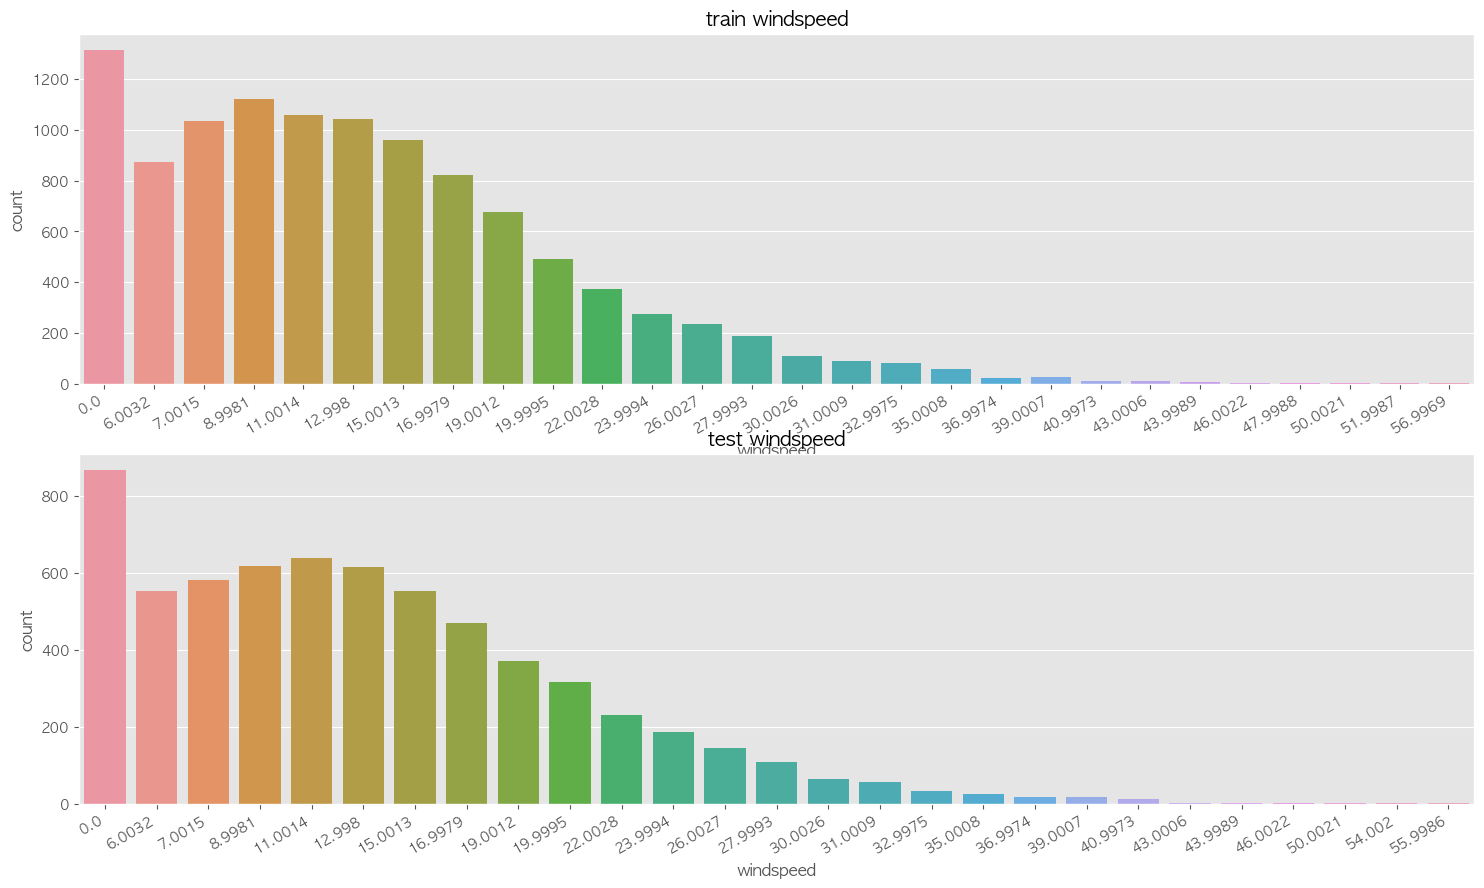

In [62]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

## Feature Selection
* 신호와 잡음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [63]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [67]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

In [68]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()


(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [69]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [70]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [71]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

## 선형회귀 모델 Linear Regression Model

* 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
* 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
* 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
* 아래 위키피디아에서 가져 온 그래프에서 파란선이 선형회귀 모델을 나타내고 빨간점들이 훈련데이터를 나타낸다.


In [72]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313504


## 릿지 Regularization Model - Ridge
* 회귀를 위한 선형모델
* 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
* Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.


In [73]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780804


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004323,0.002730,0.001229,0.000322,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.001731,0.000277,0.000831,0.000189,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.001820,0.000282,0.000912,0.000198,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.001937,0.000364,0.001148,0.000356,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.001635,0.000192,0.000724,0.000023,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [74]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


<AxesSubplot: xlabel='alpha', ylabel='rmsle'>

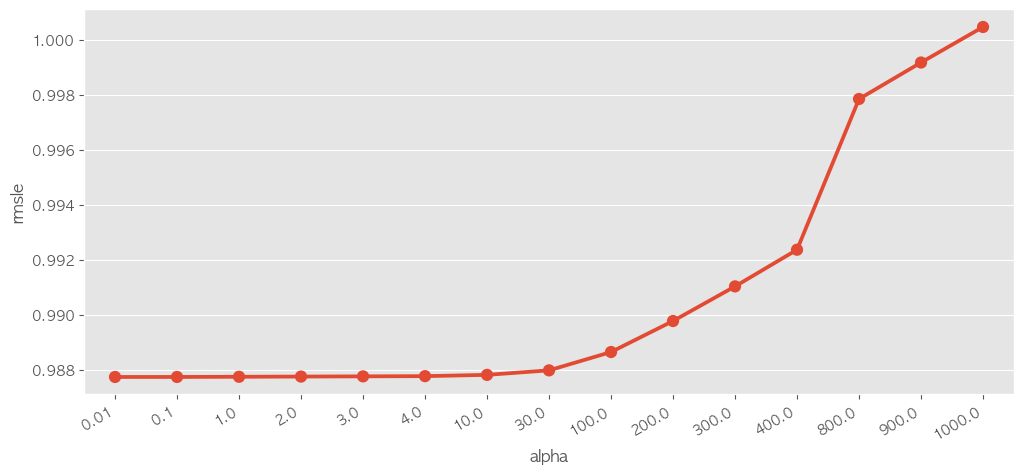

In [75]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 라쏘 Regularization Model - Lasso
* 선형회귀의 Regularization(규제)를 적용하는 대안
* 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
* 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
* alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [76]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457642


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139


<AxesSubplot: xlabel='alpha', ylabel='rmsle'>

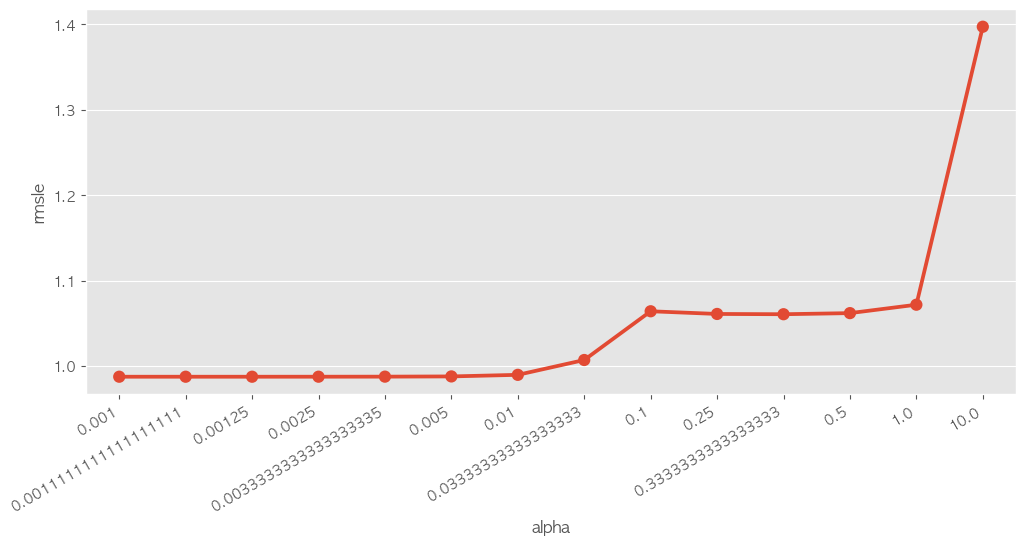

In [77]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Train

In [ ]:
# 학습
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [ ]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.69,   3.47,   3.13,   6.18,  38.32, 104.98, 235.83, 136.13,
        63.08,  64.11])

/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/1535772313.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,ax=ax1,bins=50)
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/1535772313.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions,ax=a

[Text(0.5, 1.0, 'test')]

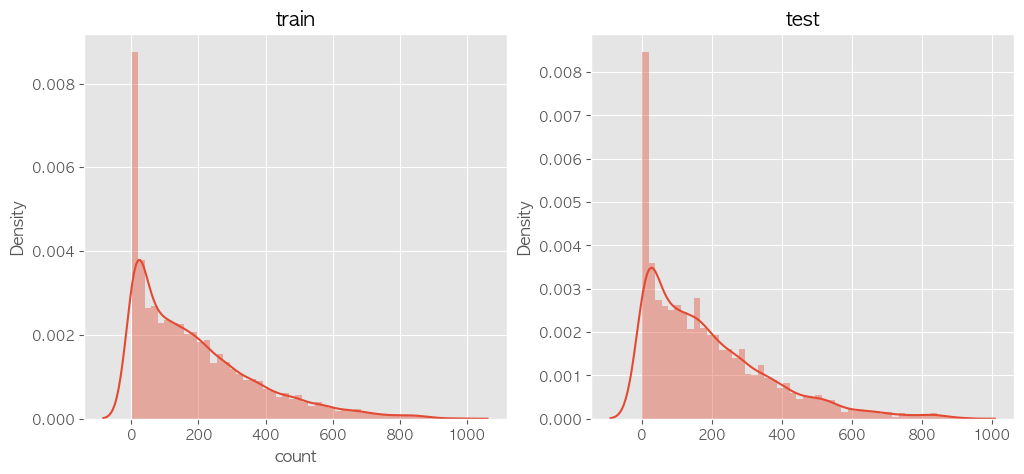

In [ ]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)

fig.set_size_inches(12,5)

sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

## Ensemble Models - Random Forest

In [78]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10716701186846922


## Ensemble Model - Gradient Boost

* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [79]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21357403727840335


/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/1927070557.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,ax=ax1,bins=50)
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_23195/1927070557.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.exp(predsTest

<AxesSubplot: ylabel='Density'>

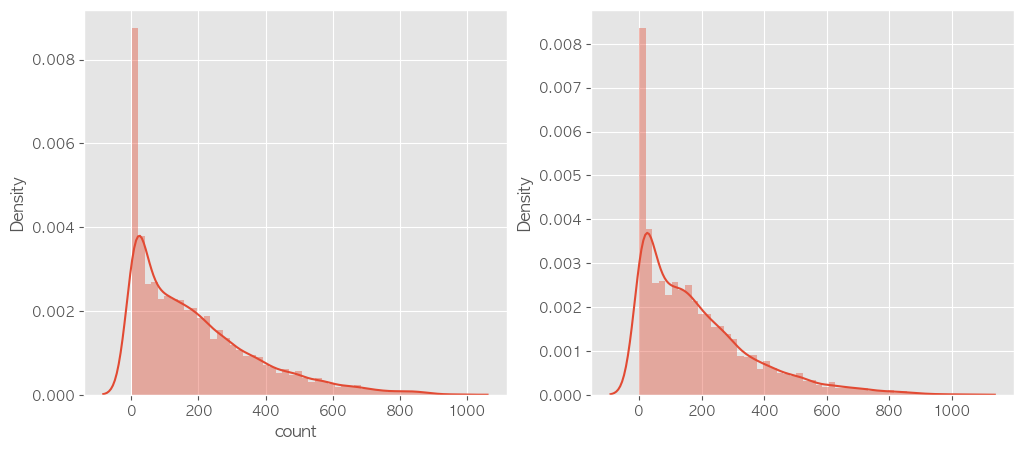

In [80]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)


## Submit

In [81]:
submission = pd.read_csv("02_bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [82]:
submission.to_csv(f"02_bike-sharing-demand/Score_{score:.5f}_submission.csv", index=False)

In [84]:
# 0.38673

print("상위 {0:}%" .format((144 / 3243) * 100 ))

상위 4.440333024976873%
